In [1]:
import os
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load train and validation dataframe

In [3]:
train = pd.read_csv('glaucoma_train.csv')
val = pd.read_csv('glaucoma_val.csv')
train

,filename,label,path,label_encoded
0,07_g.jpg,glaucoma,HRF_GLAUCOMA/07_g.jpg,1
1,05_g.jpg,glaucoma,HRF_GLAUCOMA/05_g.jpg,1
2,14_g.jpg,glaucoma,HRF_GLAUCOMA/14_g.jpg,1
3,01_g.jpg,glaucoma,HRF_GLAUCOMA/01_g.jpg,1
4,06_g.jpg,glaucoma,HRF_GLAUCOMA/06_g.jpg,1
...,...,...,...,...
1499,N-74-L.jpg,normal,RIMONE_r3_CROPPED/N-74-L.jpg,0
1500,N-43-L.jpg,normal,RIMONE_r3_CROPPED/N-43-L.jpg,0
1501,N-67-L.jpg,normal,RIMONE_r3_CROPPED/N-67-L.jpg,0
1502,N-23-L.jpg,normal,RIMONE_r3_CROPPED/N-23-L.jpg,0


## Detect imbalance classes

In [4]:
train.groupby('label').count()

,filename,path,label_encoded
label,,,
glaucoma,459,459,459
normal,1045,1045,1045


## Make sure all images can be opened

In [5]:
for path in train['path']:
    img = Image.open(path)

## Construct balance training set
- Oversample minority class
- Undersample majority class

In [6]:
NUM_SAMPLE = 900
train_balanced = pd.DataFrame(columns=train.columns)

for label in train['label'].unique():
    sub_df = train[train['label'] == label]
    sub_df_fixed = sub_df.copy()

    duplicate_n = int(NUM_SAMPLE / len(sub_df))
    for _ in range(duplicate_n): sub_df = sub_df.append(sub_df_fixed, ignore_index=True)

    sub_df = sub_df.sample(NUM_SAMPLE)
    train_balanced = train_balanced.append(sub_df, ignore_index=True)

train_balanced

,filename,label,path,label_encoded
0,Im317.jpg,glaucoma,RIMONE_r2/Glaucoma and glaucoma suspicious/Im3...,1
1,5.jpg,glaucoma,DR_HAGIS_GLAUCOMA/5.jpg,1
2,drishtiGS_066.png,glaucoma,Drishti/drishtiGS_066.png,1
3,03_g.jpg,glaucoma,HRF_GLAUCOMA/03_g.jpg,1
4,Im372.jpg,glaucoma,RIMONE_r2/Glaucoma and glaucoma suspicious/Im3...,1
...,...,...,...,...
1795,NL_191.png,normal,kaggle_ds/1_normal/NL_191.png,0
1796,Im0454_ORIGA.jpg,normal,ORIGA_NORMAL/Im0454_ORIGA.jpg,0
1797,Im0420_ORIGA.jpg,normal,ORIGA_NORMAL/Im0420_ORIGA.jpg,0
1798,Im0276_ORIGA.jpg,normal,ORIGA_NORMAL/Im0276_ORIGA.jpg,0


In [7]:
NUM_TRAIN = len(train_balanced)
train_balanced = train_balanced.sample(NUM_TRAIN)

## Load dataframe data into TensorFlow Datasets `tf.data.Dataset`

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_balanced['path'], train_balanced['label_encoded'].astype(int))).cache().shuffle(NUM_TRAIN)
val_ds = tf.data.Dataset.from_tensor_slices((val['path'], val['label_encoded'])).cache()

IMG_DIM = 380

def import_image(path, label):
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])

    return img, label

train_ds = train_ds.map(import_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(import_image, num_parallel_calls=AUTOTUNE)

tf.Tensor(1.0, shape=(), dtype=float32)
1.0


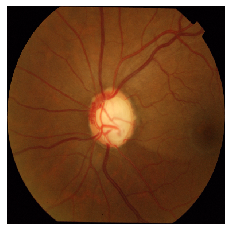

In [9]:
for img, label in train_ds.take(1):
    print(label)
    plt.imshow(img)
    plt.axis('off')
    print(np.max(img.numpy()))

## Apply augmentation on train set

In [10]:
ROTATE_ANGLE = 10/180 * math.pi

def image_augment(img, label):
    batch_size = tf.shape(img)[0]

    img = tf.image.random_flip_left_right(img)
    img = tfa.image.rotate(img, tf.random.uniform([batch_size], minval=-ROTATE_ANGLE, maxval=ROTATE_ANGLE)[0])
    
    img = tf.image.resize(img, [500, 500])
    img = tf.image.random_crop(img, [batch_size, IMG_DIM, IMG_DIM, 3])

    img = tfa.image.random_cutout(img, (100, 100))

    return img, label

In [11]:
BATCH_SIZE = 8

train_ds = train_ds.batch(BATCH_SIZE).map(image_augment)
val_ds = val_ds.batch(BATCH_SIZE)

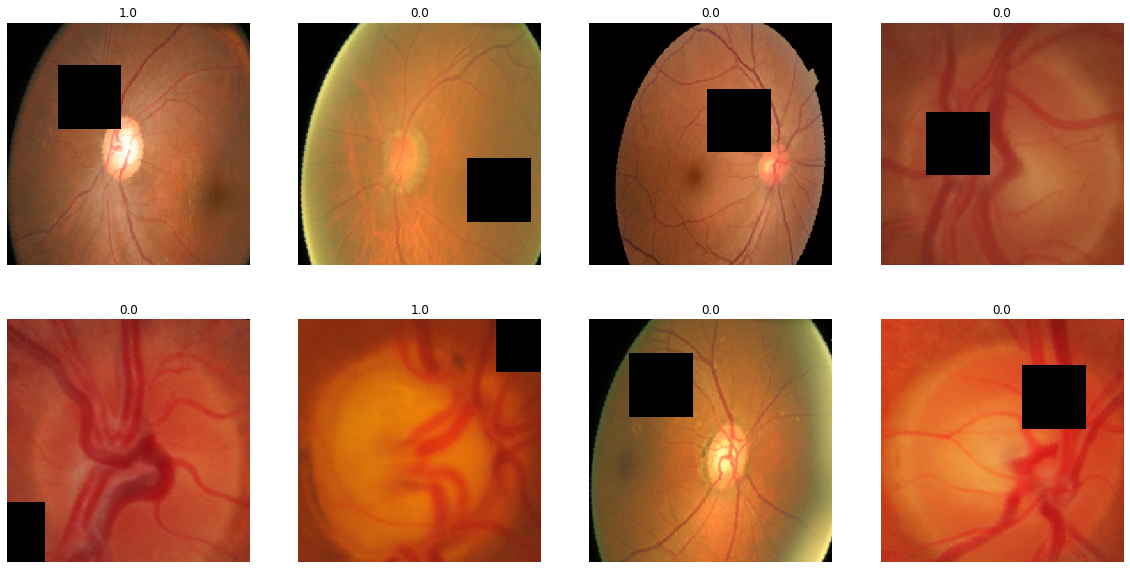

In [12]:
plt.figure(figsize=(20,10))

for imgs, labels in train_ds.take(1):
    for i in range(8):
        img = imgs[i]
        label = labels[i]

        plt.subplot(2, 4, i+1)
        plt.imshow(img.numpy())
        plt.axis('off')
        plt.title(label.numpy())

plt.savefig('image.png')

## Load model from TensorFlow Hub

In [13]:
HUB_MODEL = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'

hub.load(HUB_MODEL)
hub_model = tf.keras.models.load_model(hub.resolve(HUB_MODEL))
hub_model._name = 'efficientnet_b4'

model = tf.keras.Sequential([
    hub_model,
    tf.keras.layers.Dense(2)
])

model.build([None, IMG_DIM, IMG_DIM, 3])  # Batch input shape.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet_b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 2)                 3586      
Total params: 17,677,402
Trainable params: 17,552,202
Non-trainable params: 125,200
_________________________________________________________________


## Compile model

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

## Write custom callback to save history across all trainings

In [16]:
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

In [17]:
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # save logs
        for key in logs.keys():
            history[key].append(logs[key])
        # save learning rate
        history['lr'].append(self.model.optimizer.learning_rate.numpy())

class SaveDataCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        size = len(history['acc'])
        if size % 5 == 0:
            # save weights
            self.model.save_weights('glaucoma_publish{:03d}'.format(size))
            # save history
            with open('history_publish', 'wb') as f:
                pickle.dump(history, f)

def scheduler(epoch, lr): 
    # if (epoch+1) % 5 == 0:
        # return lr * 0.707
    return lr * tf.math.exp(-0.05)

saveHistory = SaveHistoryCallback()
saveData = SaveDataCallback()
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler) 

## Apply exponential decay to learning rate

In [18]:
_ = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[saveHistory, saveData, lrScheduler],
)

Epoch 1/10
225/225 [==============================] - 80s 354ms/step - loss: 0.8924 - acc: 0.6406 - val_loss: 0.8124 - val_acc: 0.7400
Epoch 2/10
225/225 [==============================] - 77s 344ms/step - loss: 0.8175 - acc: 0.7244 - val_loss: 0.7922 - val_acc: 0.7300
Epoch 3/10
225/225 [==============================] - 77s 344ms/step - loss: 0.7893 - acc: 0.7261 - val_loss: 0.7587 - val_acc: 0.7700
Epoch 4/10
225/225 [==============================] - 78s 347ms/step - loss: 0.7548 - acc: 0.7522 - val_loss: 0.7362 - val_acc: 0.7550
Epoch 5/10
225/225 [==============================] - 78s 346ms/step - loss: 0.7099 - acc: 0.7900 - val_loss: 0.6802 - val_acc: 0.8100
Epoch 6/10
225/225 [==============================] - 78s 347ms/step - loss: 0.7041 - acc: 0.7922 - val_loss: 0.7311 - val_acc: 0.7950
Epoch 7/10
225/225 [==============================] - 78s 346ms/step - loss: 0.6948 - acc: 0.8017 - val_loss: 0.7029 - val_acc: 0.8150
Epoch 8/10
225/225 [==============================] - 7

Review training history for early-stopping

In [19]:
def visualize_history(history):
    x = np.arange(len(history['loss']))

    fig = plt.figure(figsize=(20,6))
    plt.rcParams.update({'font.size': 14})

    plt.subplot(1,3,1)
    plt.plot(x, history['loss'])
    plt.plot(x, history['val_loss'])
    plt.legend(['Training loss', 'Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Error')

    plt.subplot(1,3,2)
    plt.plot(x, history['acc'])
    plt.plot(x, history['val_acc'])
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.title('Accuracy')

    plt.subplot(1,3,3)
    plt.plot(x, history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.title('Learning rate')

    fig.tight_layout(pad=3.0)

In [78]:
with open('history_adam2', 'rb') as f:
    hello = pickle.load(f)
hello.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

Min validation loss: 		 0.6802149415016174  at epoch  4 acc:  0.8100000023841858
Max validation accuracy: 	 0.824999988079071  at epoch  9 loss:  0.69354647397995


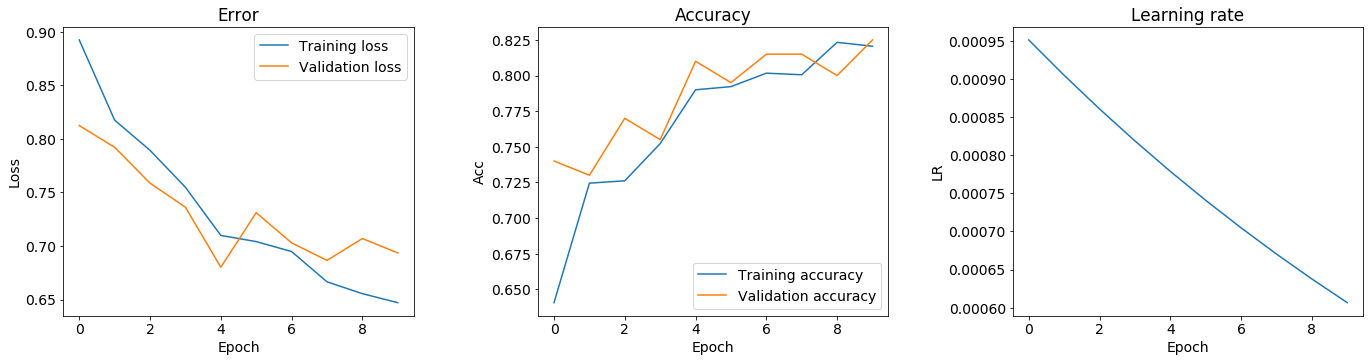

In [20]:
hello = history
visualize_history(hello)
print('Min validation loss: \t\t', min(hello['val_loss']), ' at epoch ', np.argmin(hello['val_loss']), 'acc: ', hello['val_acc'][np.argmin(hello['val_loss'])])
print('Max validation accuracy: \t', max(hello['val_acc']), ' at epoch ', np.argmax(hello['val_acc']), 'loss: ', hello['val_loss'][np.argmax(hello['val_acc'])])